In [104]:
from IPython.display import Video
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [3]:
Video('chess_1.mp4')

In [12]:
chess = cv2.VideoCapture("./chess_1.mp4")
if chess.isOpened():
    print("Video loaded")

width = int(chess.get(3))
height = int(chess.get(4))

print(height, width)

fps = chess.get(cv2.CAP_PROP_FPS)
print(fps)

Video loaded
832 720
20.0


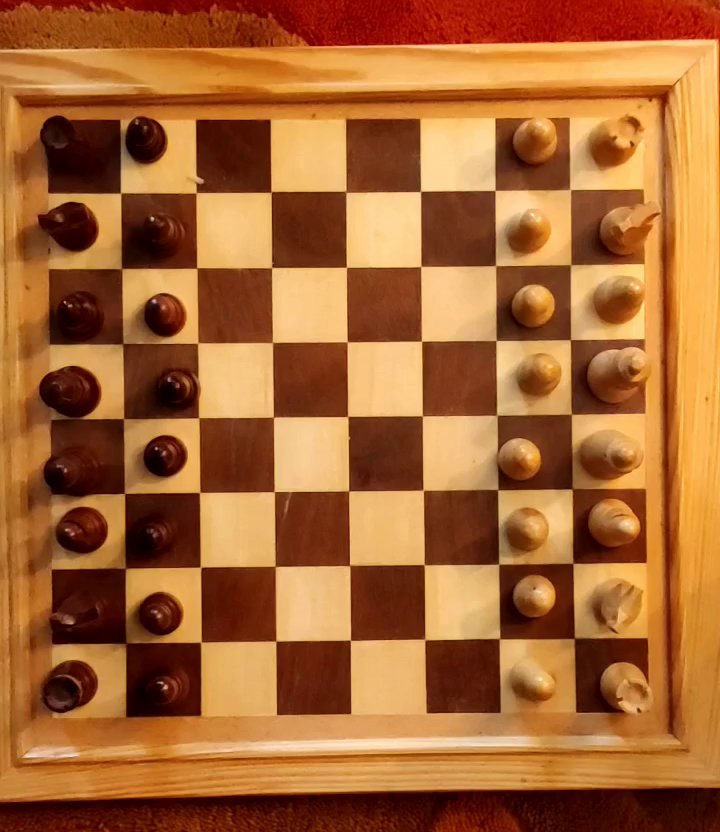

In [41]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = chess.read()
imshow(frame)

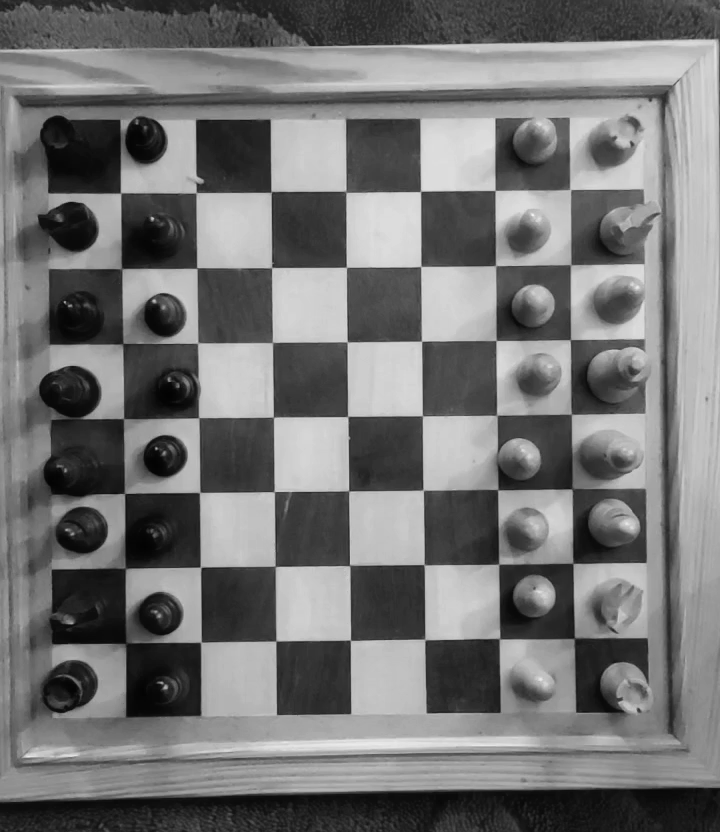

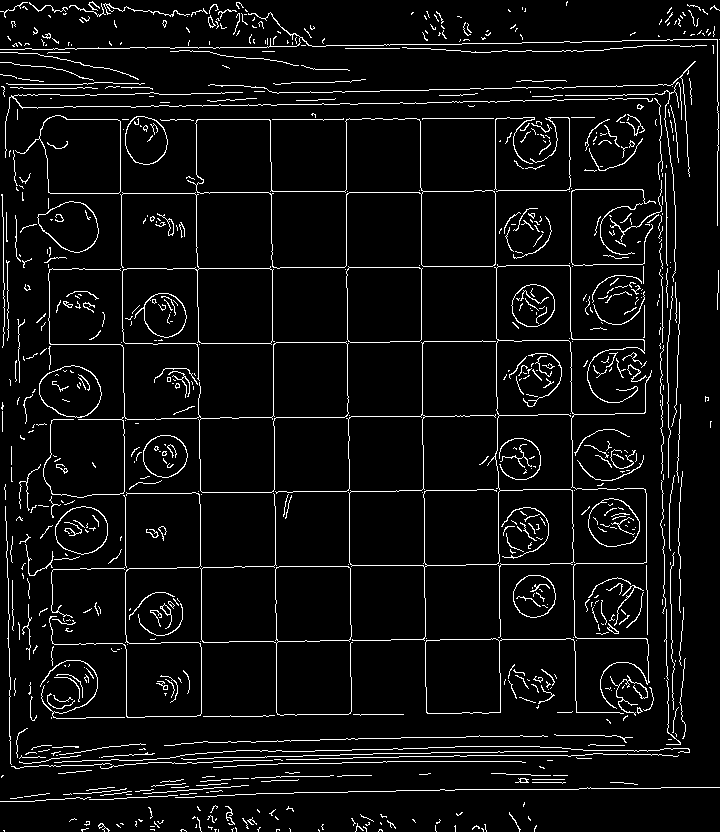

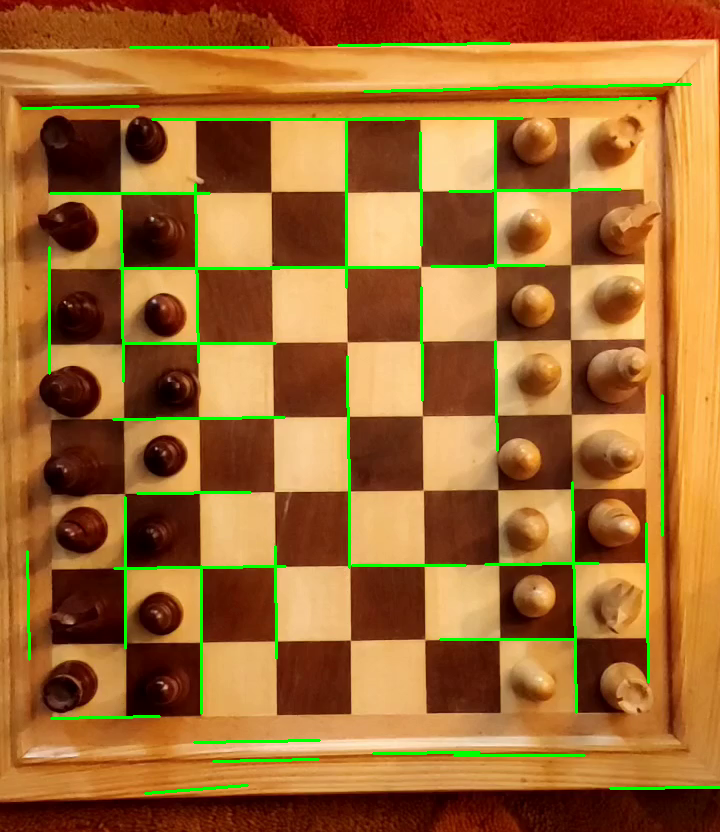

In [58]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
image = frame.copy()
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 70)  # Adjust thresholds (50 and 150) for different levels of edge detection

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

# Draw detected lines on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw lines on the original image


# Display the original and edge-detected images
imshow(gray)
imshow(edges)
imshow(image)



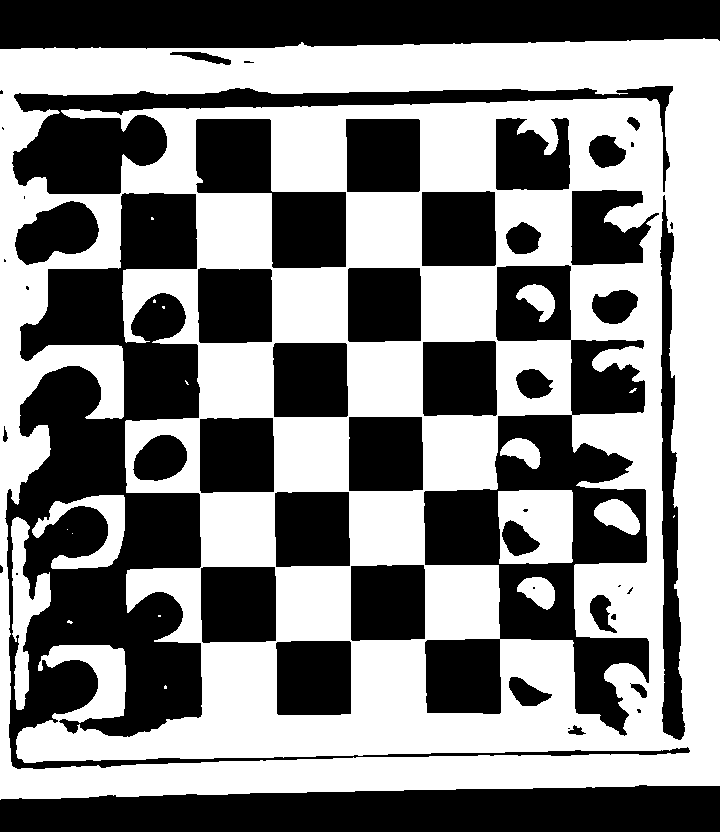

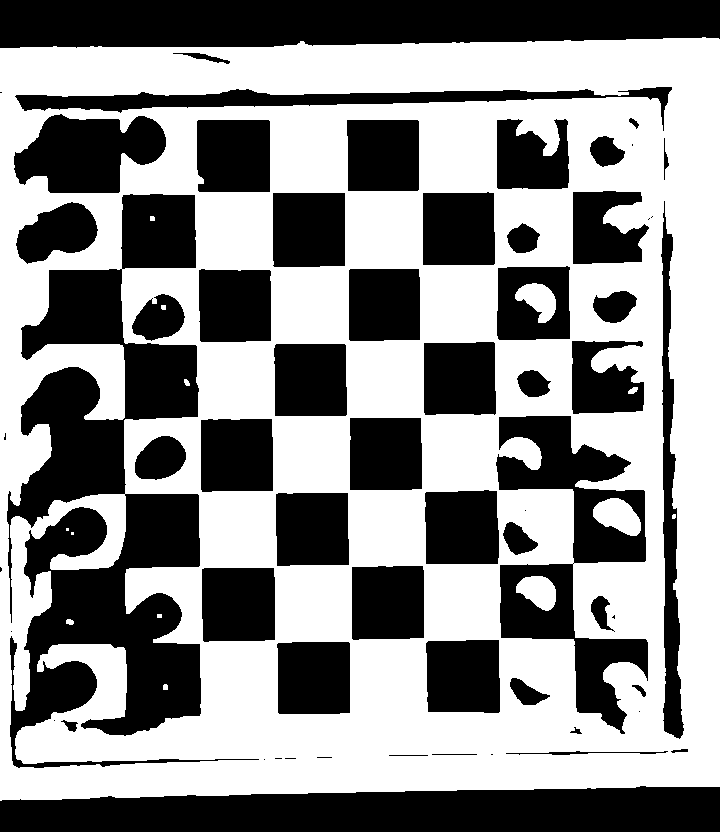

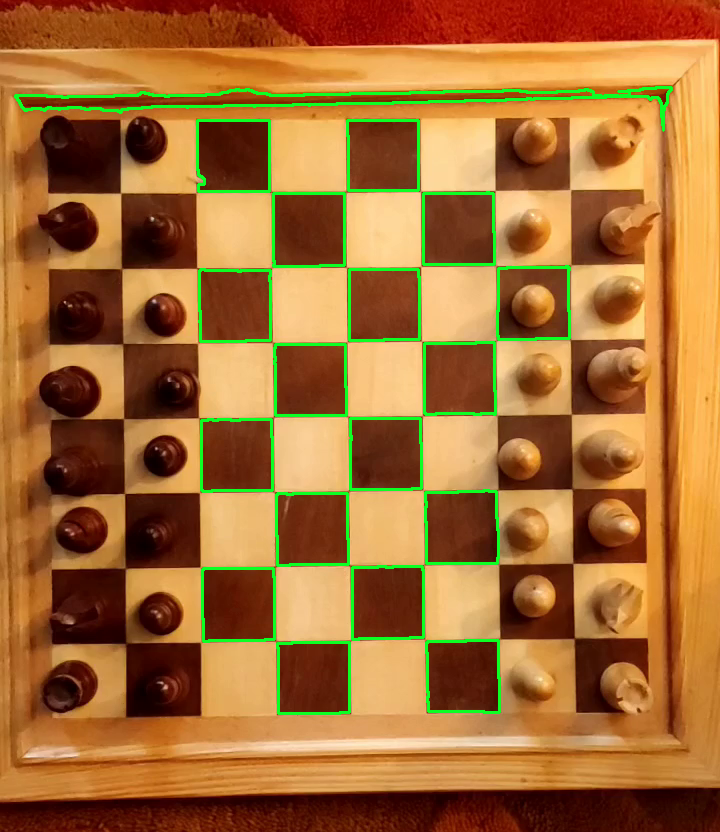

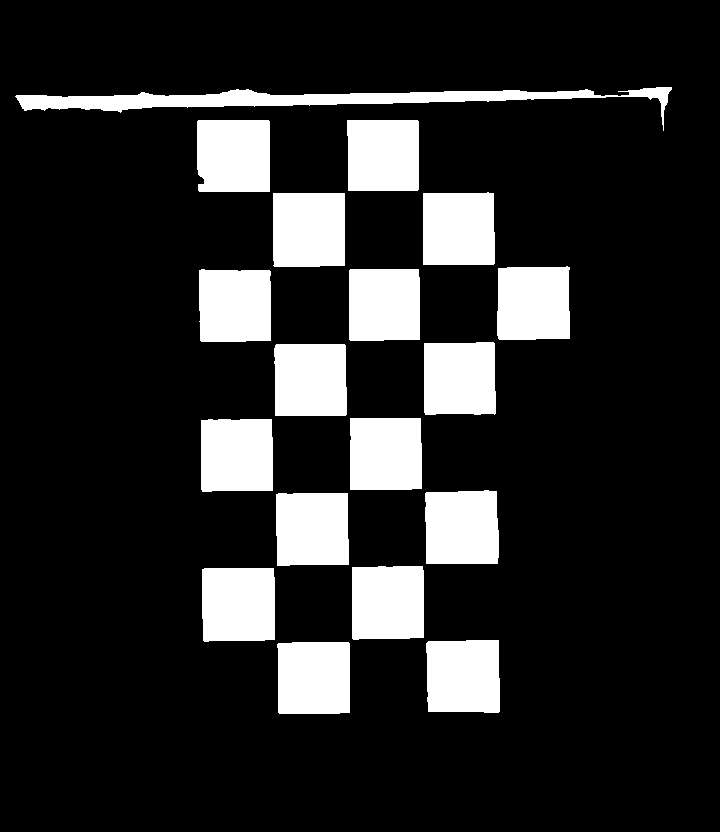

In [60]:
image = frame.copy()
mask = np.zeros(image.shape, dtype=np.uint8)
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Remove noise with morph operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.dilate(thresh, kernel=np.ones((3,3)))
invert = 255 - opening

# Find contours and find squares with contour area filtering + shape approximation
cnts = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4 and area > 100 and area < 10000:
        x,y,w,h = cv2.boundingRect(c)
        cv2.drawContours(original, [c], -1, (36,255,12), 2)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)

imshow(thresh)
imshow(opening)
imshow(original)
imshow(mask)

In [101]:
from scipy import ndimage
from scipy.spatial import distance
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import bisect

# Function to calculate centroids of regions with value 1
def calculate_centroids(array):
    # Label connected components
    labeled_array, num_features = ndimage.label(array)

    # Find centroids of each labeled region
    centroids = []
    for label in range(1, num_features + 1):  # Labels start from 1
        region_indices = np.where(labeled_array == label)
        centroid_y = np.mean(region_indices[0])
        centroid_x = np.mean(region_indices[1])
        centroids.append((centroid_x, centroid_y))

    return centroids

def dominant_distance_from_neighbors(points):
    # List to store distances
    distances = []

    # Calculate pairwise distances between points
    for i, point in enumerate(points):
        # Calculate distances from all other points
        dists = [np.round(distance.euclidean(point, other)) for j, other in enumerate(points) if i != j]
        # Sort distances and consider only the 5 closest neighbors
        closest_distances = sorted(dists)[:5]
        # Add the 5 closest distances to the list
        distances.extend(closest_distances)

    # Find the most common distance among the 5 closest neighbors
    dominant_distance = Counter(distances).most_common(1)[0][0]

    return dominant_distance

def find_points_within_distance(points, target_distance):
    # Initialize Nearest Neighbors model
    nn_model = NearestNeighbors(n_neighbors=3)  # Considering 2 closest neighbors and the point itself
    nn_model.fit(points)

    # Find distances to 2 closest neighbors for each point
    distances, indices = nn_model.kneighbors(points, n_neighbors=3, return_distance=True)

    # Select points satisfying the condition
    subset_points = list()
    for i, point in enumerate(points):
        # Calculate distances from all other points
        dists = [np.round(distance.euclidean(point, other)) for j, other in enumerate(points) if i != j]
        dists.sort()
        index_lower = bisect.bisect_left(dists, 73)
        index_upper = bisect.bisect_left(dists, 77)

        # Check if there is a value within the range
        is_in_range = index_lower != index_upper and index_lower < len(dists)

        if is_in_range:
            subset_points.append(point)

    
    
    return subset_points

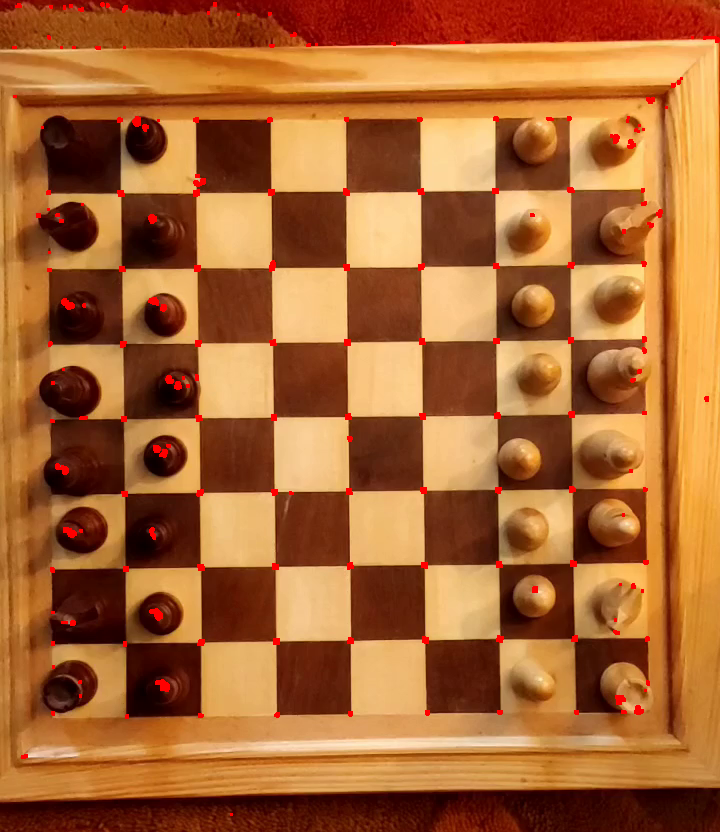

[(102.0, 4.0), (214.5, 4.0), (18.137931034482758, 5.310344827586207), (107.33333333333333, 5.0), (70.5, 5.5), (50.6, 6.4), (64.0, 7.0), (124.4054054054054, 8.297297297297296), (80.84, 9.08), (208.0, 12.5), (269.4, 13.4), (238.0, 14.0), (293.22222222222223, 34.333333333333336), (48.5, 37.0), (692.0, 37.0), (711.8985507246376, 38.072463768115945), (457.0, 42.0), (393.1666666666667, 43.333333333333336), (308.1666666666667, 44.666666666666664), (316.0, 44.0), (271.5, 45.36363636363637), (14.0, 47.0), (61.0, 47.0), (73.5, 47.0), (97.6086956521739, 47.43478260869565), (124.0, 47.0), (679.25, 80.64285714285714), (672.9166666666666, 84.91666666666667), (14.5, 96.0), (650.0754716981132, 99.66037735849056), (666.0, 107.0), (136.49367088607596, 121.0886075949367), (495.64516129032256, 118.41935483870968), (568.8260869565217, 118.0), (627.4285714285714, 119.0), (119.3225806451613, 119.58064516129032), (195.75, 119.5), (269.375, 119.5), (346.0833333333333, 118.91666666666667), (419.32142857142856, 

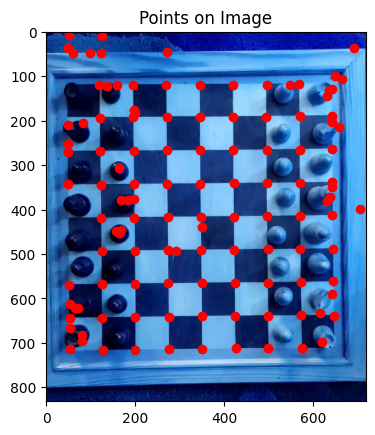

In [107]:
img_blocks = frame.copy()
img_blocks_gray = cv2.cvtColor(img_blocks, cv2.COLOR_BGR2GRAY)
img_blocks_gray = img_blocks_gray.astype(np.float32)

dst = cv2.cornerHarris(img_blocks_gray, 3, 3, 0.04)
# result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img_blocks[dst > 0.01 * dst.max()] = [0, 0, 255]
imshow(img_blocks)



# Example 2D array (0s and 1s)
input_array = dst > 0.01 * dst.max()

# Calculate centroids of regions with value 1
centroids = calculate_centroids(input_array == 1)
print(centroids)

points_array = np.array(centroids)

# Calculate the dominant distance from the 5 closest neighbors
dominant_dist = dominant_distance_from_neighbors(points_array)
print(f"Dominant distance from 5 closest neighbors: {dominant_dist}")

result_subset = find_points_within_distance(centroids, 75)
print("Subset of points satisfying the distance condition:")
print(result_subset)
print(len(result_subset))


plt.imshow(frame)
plt.scatter([point[0] for point in result_subset], [point[1] for point in result_subset], color='red', marker='o')
plt.title('Points on Image')
plt.show()